<a href="https://colab.research.google.com/github/Jayaprakash1710/Computer-Vision-Ninjacart/blob/main/Ninjacart_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File link: https://drive.google.com/file/d/1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT/view?usp=sharing

In [1]:
!gdown 1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT

Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=46a90967-28c4-4e99-adb3-ee5fdae7c2dc
To: /content/ninjacart_data.zip
100% 275M/275M [00:02<00:00, 133MB/s]


In [2]:
!unzip /content/ninjacart_data.zip

Archive:  /content/ninjacart_data.zip
   creating: ninjacart_data/test/
   creating: ninjacart_data/test/indian market/
  inflating: ninjacart_data/test/indian market/bhl.jpeg  
  inflating: ninjacart_data/test/indian market/bhv.jpeg  
  inflating: ninjacart_data/test/indian market/bn.jpeg  
  inflating: ninjacart_data/test/indian market/hjx.jpeg  
  inflating: ninjacart_data/test/indian market/igis.jpeg  
  inflating: ninjacart_data/test/indian market/in.jpeg  
  inflating: ninjacart_data/test/indian market/india-4898453__340.jpg  
  inflating: ninjacart_data/test/indian market/indianmarket10.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket12.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket13.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket14.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket15.jpeg  
  inflating: ninjacart_data/test/indian market/indianmarket18.jpeg  
  inflating: ninjacart_data/test/indian market/

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import random
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

%matplotlib inline

In [4]:
def visualize_image_counts(dataset_type='train'):
    base_path = '/content/ninjacart_data'
    folder_path = os.path.join(base_path, dataset_type)
    class_counts = {}

    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            count = len(os.listdir(class_dir))
            class_counts[class_name] = count

    total_images = sum(class_counts.values())

    # Plotting
    plt.figure(figsize=(8, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title(f"Image Count per Class in {dataset_type.capitalize()} Set")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height),
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print class-wise and total count below the plot
    print("\nClass-wise counts:")
    for cls, count in class_counts.items():
        print(f"{cls} - {count}")
    print(f"Total {dataset_type} images - {total_images}")

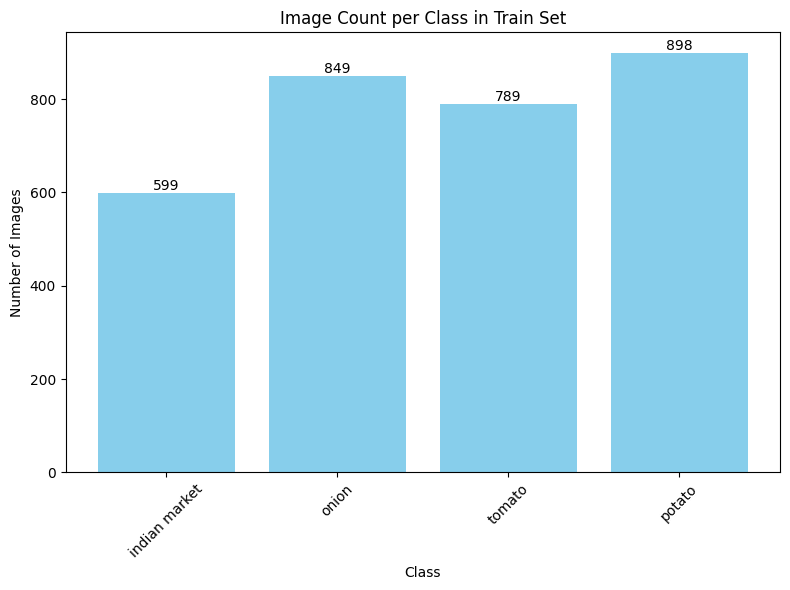


Class-wise counts:
indian market - 599
onion - 849
tomato - 789
potato - 898
Total train images - 3135


In [5]:
visualize_image_counts('train')

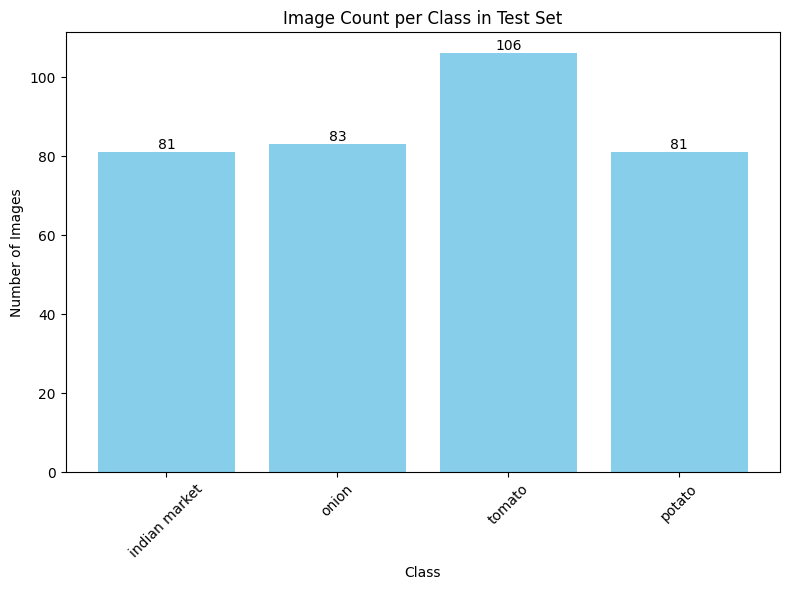


Class-wise counts:
indian market - 81
onion - 83
tomato - 106
potato - 81
Total test images - 351


In [6]:
visualize_image_counts("test")

In [7]:
def create_validation_split(train_dir='/content/ninjacart_data/train', val_dir='/content/ninjacart_data/val', val_split=0.15):
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(train_dir):
        class_train_path = os.path.join(train_dir, class_name)
        class_val_path = os.path.join(val_dir, class_name)

        if not os.path.isdir(class_train_path):
            continue

        os.makedirs(class_val_path, exist_ok=True)

        images = os.listdir(class_train_path)
        random.shuffle(images)

        val_count = int(len(images) * val_split)
        val_images = images[:val_count]

        for img in val_images:
            src_path = os.path.join(class_train_path, img)
            dst_path = os.path.join(class_val_path, img)
            shutil.move(src_path, dst_path)

    print("Validation split created.")

In [8]:
create_validation_split()

Validation split created.


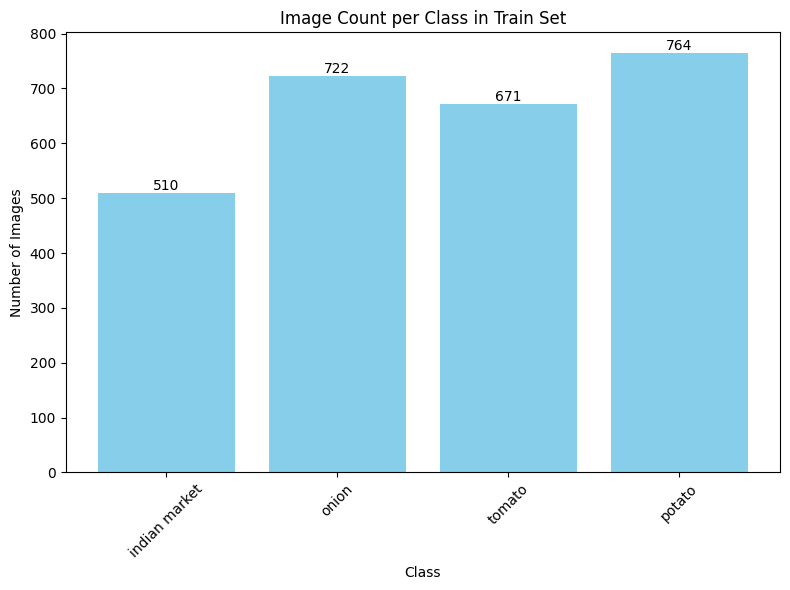


Class-wise counts:
indian market - 510
onion - 722
tomato - 671
potato - 764
Total train images - 2667


In [9]:
visualize_image_counts("train")

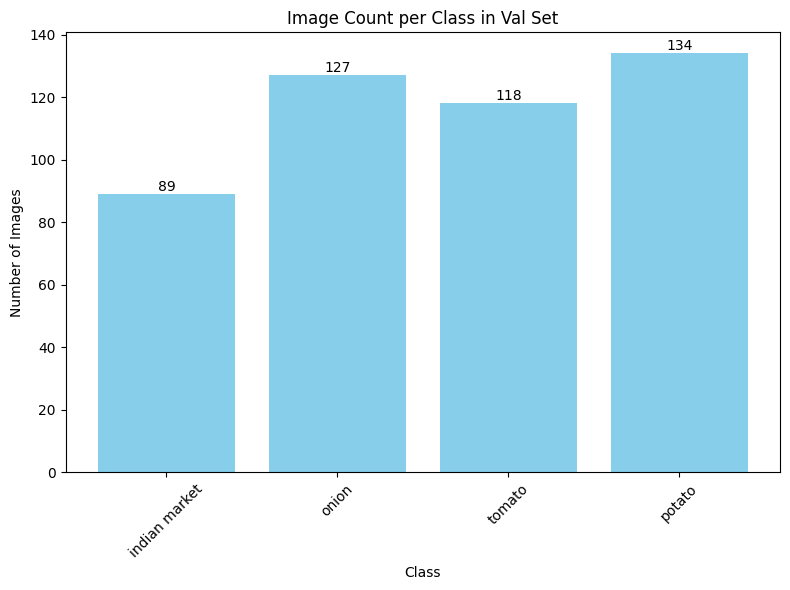


Class-wise counts:
indian market - 89
onion - 127
tomato - 118
potato - 134
Total val images - 468


In [10]:
visualize_image_counts("val")

In [11]:
def show_sample_images(train_dir='/content/ninjacart_data/train', samples_per_class=5):
    class_names = sorted(os.listdir(train_dir))
    plt.figure(figsize=(samples_per_class * 3, len(class_names) * 3))

    img_index = 1
    for class_name in class_names:
        class_path = os.path.join(train_dir, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)
        images = images[:samples_per_class]

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, _ = img.shape

            plt.subplot(len(class_names), samples_per_class, img_index)
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title(f"{class_name}\n{w}x{h}")
            img_index += 1

    plt.tight_layout()
    plt.show()

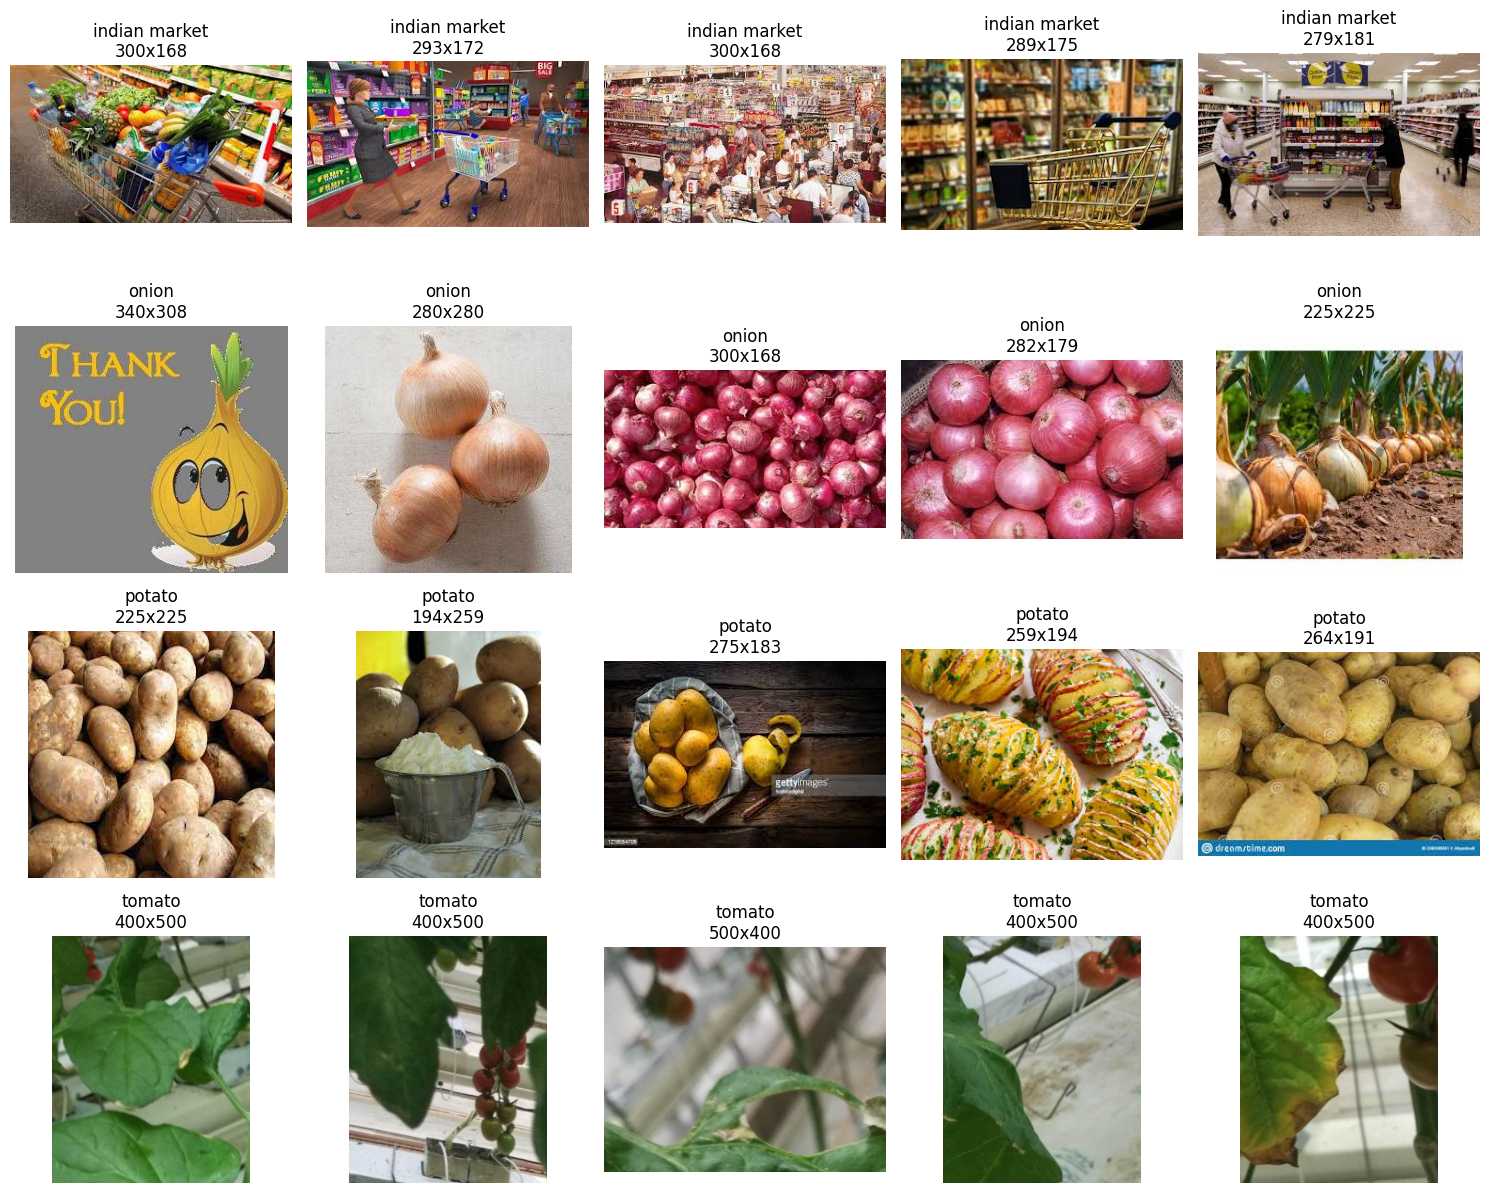

In [13]:
show_sample_images()

Loading the data into variables:

In [17]:
def load_data(base_dir="/content/ninjacart_data"):
    # checking if the data folders are present
    assert os.path.exists(f"{base_dir}/train") and os.path.exists(f"{base_dir}/val") and os.path.exists(f"{base_dir}/test")

    print('\nLoading Data...')
    train_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/train", shuffle=True, label_mode='categorical'
    )
    val_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/val", shuffle=False, label_mode='categorical'
    )
    test_data = tf.keras.utils.image_dataset_from_directory(
        f"{base_dir}/test", shuffle=False, label_mode='categorical'
    )
    return train_data, val_data, test_data, train_data.class_names

In [18]:
train_data, val_data, test_data, class_names = load_data()


Loading Data...
Found 2667 files belonging to 4 classes.
Found 468 files belonging to 4 classes.
Found 351 files belonging to 4 classes.


Resizing and Rescaling images:

In [26]:
def preprocess(train_data, val_data, test_data, target_height=224, target_width=224):

    # Data Processing Stage with resizing and rescaling operations
    data_preprocess = keras.Sequential(
        name="data_preprocess",
        layers=[
            layers.Resizing(target_height, target_width),
            layers.Rescaling(1.0/255),
        ]
    )

    # Perform Data Processing on the train, val, test dataset
    train_ds = train_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_data.map(lambda x, y: (data_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [27]:
train_ds, val_ds, test_ds = preprocess(train_data, val_data, test_data)

In [28]:
train_ds

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

#Base Line model

In [29]:
def baseline(height=224, width=224):
    num_classes = 4
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn",
        layers=[
            layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(units=hidden_size, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [30]:
model = baseline()
model.summary()

Model: "model_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 802816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │   205,521,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,523,972 (784.01 MB)

 Trainable params: 205,523,972 (784.01 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
def compile_train_v1(model, train_ds, val_ds, ckpt_path="/tmp/checkpoint.weights.h5"):
    epochs = 10
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    ])
    return model_fit

In [32]:
model_fit = compile_train_v1(model, train_ds, val_ds)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 49s 507ms/step - accuracy: 0.4700 - loss: 24.1076 - val_accuracy: 0.7543 - val_loss: 0.6323
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 35s 421ms/step - accuracy: 0.8392 - loss: 0.4760 - val_accuracy: 0.7799 - val_loss: 0.5098
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 437ms/step - accuracy: 0.8993 - loss: 0.2553 - val_accuracy: 0.8141 - val_loss: 0.4984
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - accuracy: 0.9704 - loss: 0.0981 - val_accuracy: 0.7970 - val_loss: 0.5809
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.9864 - loss: 0.0544 - val_accuracy: 0.8013 - val_loss: 0.6023
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.9900 - loss: 0.0364 - val_accuracy: 0.7906 - val_loss: 0.6641
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.9950 - loss: 0.0239 - val_accuracy: 0.8098 - val_loss: 0.7306
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9977 - loss: 0.0130 - val_accu

In [33]:
def annot_max(x,y, xytext=(0.94,0.96), ax=None, only_y=True):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    if only_y:
        text = "{:.2f}%".format(ymax)
    else:
        text= "x={:.2f}, y={:.2f}%".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=xytext, **kw)

def plot_accuracy(model_fit):
    #accuracy graph
    x = range(0,len(model_fit.history['accuracy']))
    y_train = [acc * 100 for acc in model_fit.history['accuracy']]
    y_val = [acc * 100 for acc in model_fit.history['val_accuracy']]

    plt.plot(x, y_train, label='Train', color='b')
    annot_max(x, y_train, xytext=(0.7,0.9))
    plt.plot(x, y_val, label='Val', color='r')
    annot_max(x, y_val, xytext=(0.8,0.7))
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

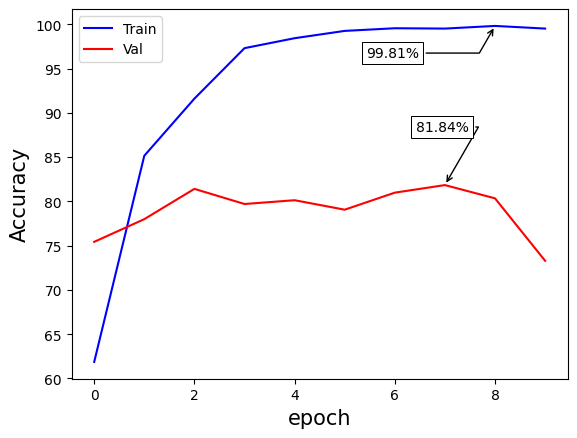

In [34]:
plot_accuracy(model_fit)

In [35]:
def print_accuracy_stats(model, ds, class_names):
    model.load_weights("/tmp/checkpoint.weights.h5")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)

    test_acc = accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')

# Note: This doesn't work with shuffled datasets
def plot_confusion_matrix(model, ds, class_names):
    model.load_weights("/tmp/checkpoint.weights.h5")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    cm = confusion_matrix(true_categories,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu", fmt='g')
    plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step

Test Accuracy: 77.21%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


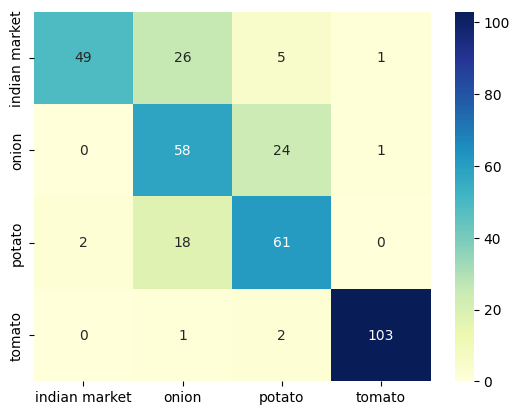

In [36]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Architecture-1

In [37]:
def arch_1(height=224, width=224):
    num_classes = 4
    hidden_size = 512

    model = keras.Sequential(
        name="model_cnn_1",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=512, kernel_size=3, padding="same", activation='relu'),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [38]:
model = arch_1()
model.summary()

Model: "model_cnn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,837,476 (7.01 MB)

 Trainable params: 1,837,476 (7.01 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
def compile_train_v1(model, train_ds, val_ds, epochs=10, ckpt_path="/tmp/checkpoint.weights.h5"):
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    ])
    return model_fit

In [40]:
model_fit = compile_train_v1(model, train_ds, val_ds)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - accuracy: 0.3519 - loss: 1.2670 - val_accuracy: 0.6966 - val_loss: 0.7186
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.6553 - loss: 0.7424 - val_accuracy: 0.7030 - val_loss: 0.6431
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.7086 - loss: 0.6455 - val_accuracy: 0.7607 - val_loss: 0.5643
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.7709 - loss: 0.5604 - val_accuracy: 0.8162 - val_loss: 0.5352
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.7919 - loss: 0.5274 - val_accuracy: 0.8056 - val_loss: 0.4214
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.8148 - loss: 0.4599 - val_accuracy: 0.8397 - val_loss: 0.3825
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.8360 - loss: 0.3993 - val_accuracy: 0.8226 - val_loss: 0.3681
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.8610 - loss: 0.3539 - val_accuracy

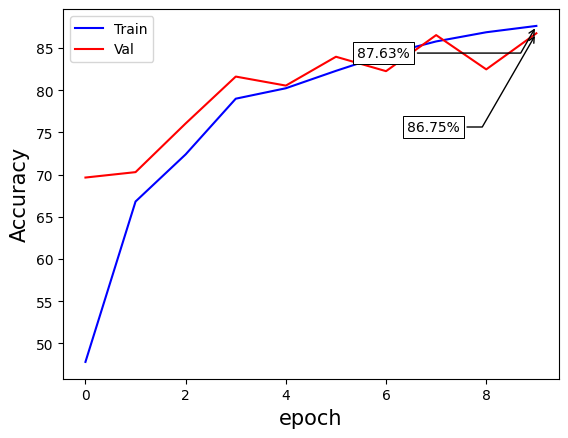

In [41]:
plot_accuracy(model_fit)

In [42]:
model_fit = compile_train_v1(model, train_ds, val_ds, epochs=30)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.8342 - loss: 0.4176 - val_accuracy: 0.8504 - val_loss: 0.3771
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.8746 - loss: 0.3045 - val_accuracy: 0.8825 - val_loss: 0.2979
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.8760 - loss: 0.3071 - val_accuracy: 0.8697 - val_loss: 0.3431
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.8881 - loss: 0.2963 - val_accuracy: 0.8953 - val_loss: 0.2713
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.8877 - loss: 0.2815 - val_accuracy: 0.8483 - val_loss: 0.3776
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.8848 - loss: 0.2731 - val_accuracy: 0.8547 - val_loss: 0.3901
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.8974 - loss: 0.2610 - val_accuracy: 0.8697 - val_loss: 0.3207
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9010 - loss: 0.2377 - val_accuracy

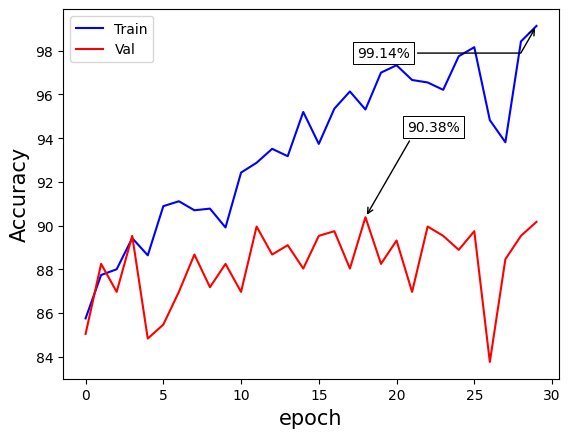

In [43]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step

Test Accuracy: 84.62%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


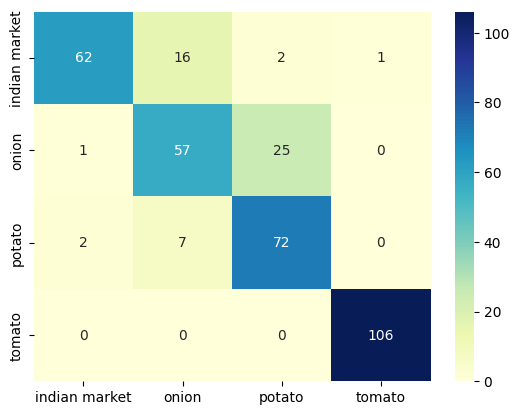

In [44]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Architecture-2

In [45]:
def arch_2(height=224, width=224):
    num_classes = 4
    hidden_size = 512

    model = keras.Sequential(
        name="model_cnn_2",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=512, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [46]:
model = arch_2()
model.summary()

Model: "model_cnn_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,843,556 (7.03 MB)

 Trainable params: 1,840,516 (7.02 MB)

 Non-trainable params: 3,040 (11.88 KB)

In [47]:
model_fit = compile_train_v1(model, train_ds, val_ds, epochs=30)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 173ms/step - accuracy: 0.6606 - loss: 1.0802 - val_accuracy: 0.3333 - val_loss: 2.7011
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.7725 - loss: 0.6803 - val_accuracy: 0.3504 - val_loss: 2.6578
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.8068 - loss: 0.5680 - val_accuracy: 0.5128 - val_loss: 1.2178
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.8353 - loss: 0.4713 - val_accuracy: 0.5855 - val_loss: 1.4032
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.8436 - loss: 0.4558 - val_accuracy: 0.6175 - val_loss: 1.2100
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.8614 - loss: 0.3537 - val_accuracy: 0.6624 - val_loss: 0.9726
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.8517 - loss: 0.3966 - val_accuracy: 0.7436 - val_loss: 0.6911
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.8447 - loss: 0.4129 - val_accur

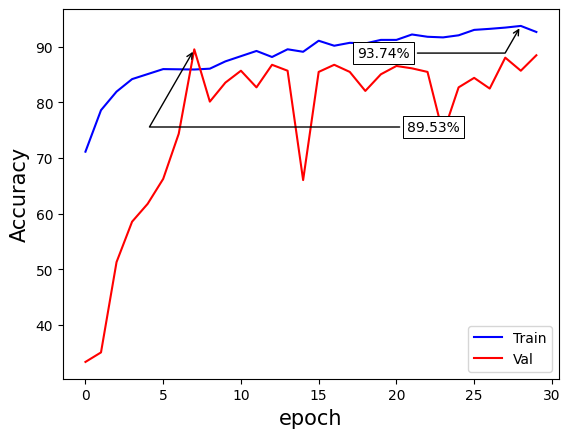

In [48]:
plot_accuracy(model_fit)

In [49]:
def compile_train_v2(model, train_ds, val_ds, epochs=10, ckpt_path="/tmp/checkpoint.weights.h5"):
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=10, min_lr=0.00001
        ),
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, min_delta=0.001, mode='min'
        )
    ]
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return model_fit

In [50]:
model = arch_2()
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.6524 - loss: 1.1725 - val_accuracy: 0.3248 - val_loss: 2.6602 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.7541 - loss: 0.6980 - val_accuracy: 0.3611 - val_loss: 1.8462 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.7896 - loss: 0.5840 - val_accuracy: 0.5064 - val_loss: 1.7615 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.8247 - loss: 0.5189 - val_accuracy: 0.4744 - val_loss: 2.4313 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.8202 - loss: 0.5281 - val_accuracy: 0.6645 - val_loss: 1.1057 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.8309 - loss: 0.4449 - val_accuracy: 0.7073 - val_loss: 0.8503 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.8528 - loss

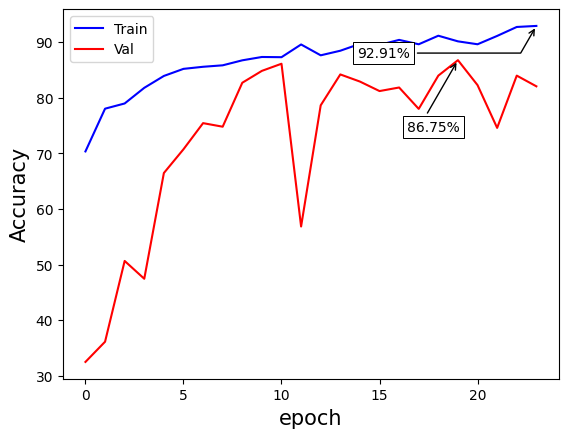

In [51]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step

Test Accuracy: 80.63%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


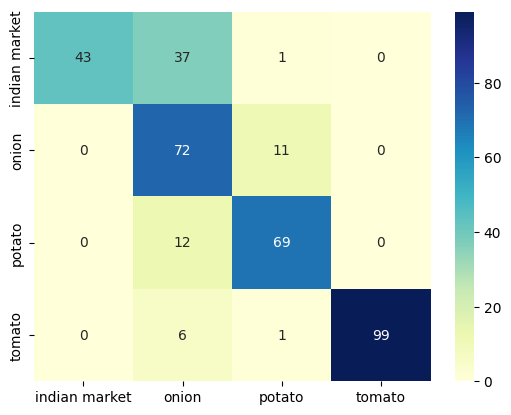

In [52]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Architecture-3

In [53]:
def arch_3(height=224, width=224):
    num_classes = 4
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_3",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3),
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            # layers.MaxPooling2D(),
            # layers.Flatten(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [54]:
model = arch_3()
model.summary()

Model: "model_cnn_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 256)            │             

 Total params: 462,436 (1.76 MB)

 Trainable params: 460,932 (1.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [55]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 172ms/step - accuracy: 0.6492 - loss: 1.6706 - val_accuracy: 0.4573 - val_loss: 1.9615 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.7894 - loss: 1.2157 - val_accuracy: 0.4338 - val_loss: 1.7900 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.8091 - loss: 1.0902 - val_accuracy: 0.4295 - val_loss: 2.0218 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.8162 - loss: 1.0429 - val_accuracy: 0.6453 - val_loss: 1.5297 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.8276 - loss: 0.9620 - val_accuracy: 0.6474 - val_loss: 1.5704 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.8503 - loss: 0.8678 - val_accuracy: 0.7863 - val_loss: 0.9732 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.8638 - los

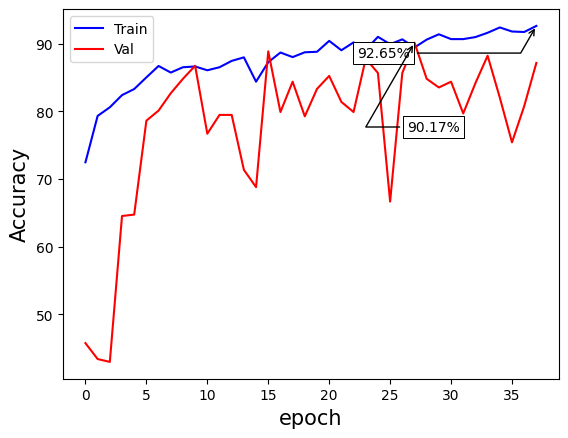

In [56]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step

Test Accuracy: 89.17%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


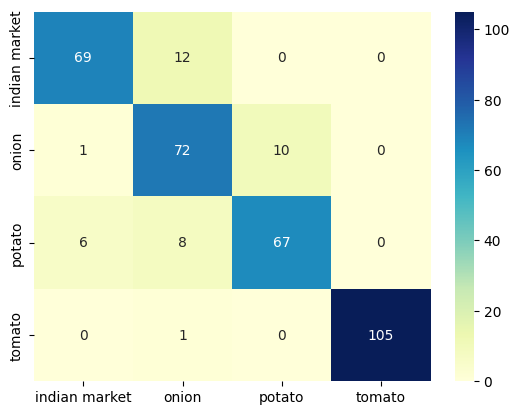

In [57]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Data Augmentation

In [64]:
def get_augmented_train_ds(path, img_size=(224, 224), batch_size=32):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomCrop(img_size[0], img_size[1])
    ])

    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        path,
        image_size=img_size,
        batch_size=batch_size
    )

    class_names = raw_train_ds.class_names
    num_classes = len(class_names)

    # Apply augmentation + one-hot + performance tweaks
    augmented_train_ds = raw_train_ds.map(
        lambda x, y: (data_augmentation(x), tf.one_hot(y, depth=num_classes)),
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

    return augmented_train_ds, class_names

In [65]:
train_ds, class_names = get_augmented_train_ds('/content/ninjacart_data/train')

Found 2667 files belonging to 4 classes.


In [66]:
model = arch_3()
model.summary()

Model: "model_cnn_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 256)            │             

 Total params: 462,436 (1.76 MB)

 Trainable params: 460,932 (1.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [ ]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 56s 549ms/step - accuracy: 0.2398 - loss: 2.7153 - val_accuracy: 0.2521 - val_loss: 1.9739 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 74s 517ms/step - accuracy: 0.2598 - loss: 2.4624 - val_accuracy: 0.2714 - val_loss: 1.9555 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 497ms/step - accuracy: 0.2458 - loss: 2.3245 - val_accuracy: 0.2714 - val_loss: 1.9475 - learning_rate: 0.0010
Epoch 4/100
24/84 ━━━━━━━━━━━━━━━━━━━━ 29s 489ms/step - accuracy: 0.2715 - loss: 2.2207

In [ ]:
plot_accuracy(model_fit)

In [ ]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)